# Package Setup

In [1]:
# Install packages
install.packages("rstan")
install.packages("loo")
install.packages("posterior")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Load packages
library(rstan)
library(loo)
library(posterior)

Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


This is loo version 2.8.0

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 


Attaching package: ‘loo’


The following object is masked from ‘package:rstan’:

    loo


This is posterior version 1.6.1


Attaching package: ‘posterior’


The following objects are masked from ‘package:rstan’:

    ess_bulk, ess_tail


The following objects are masked from ‘pa

In [3]:
# Configure Stan for parallel execution
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

# Utility Functions

In [4]:
#' Convert mean/variance to log-normal parameters
#'
#' @param mean Target mean of log-normal distribution
#' @param variance Target variance of log-normal distribution
#' @return List with meanlog and sdlog parameters
lognormal_params <- function(
    mean,
    variance
) {
    stopifnot(
        mean > 0,
        variance > 0
    )
    cv_squared <- variance / mean^2
    meanlog <- log(mean) - 0.5 * log(1 + cv_squared)
    sdlog <- sqrt(
        log(1 + cv_squared)
    )
    list(
        meanlog = meanlog,
        sdlog = sdlog
    )
}

In [5]:
#' Plot posterior density with credible interval
#'
#' @param samples MCMC samples
#' @param true_val True parameter value (optional)
#' @param param_name Parameter name for x-axis label
#' @param xlim Plot limits (optional)
#' @param ci_level Credible interval level (default 0.95)
#' @param col_density Color for density line (default "black")
#' @param col_true Color for true value line (default "red")
plot_posterior <- function(
    samples,
    true_val = NULL,
    param_name = "",
    xlim = NULL,
    ci_level = 0.95,
    col_density = "black",
    col_true = "red"
) {
    # Compute density
    dens <- density(samples)
    if (is.null(xlim)) {
        xlim <- range(dens$x)
    }

    # Main density plot
    plot(
        dens,
        main = "",
        xlab = param_name,
        xlim = xlim,
        col = col_density,
        lwd = 1.5
    )

    # Add credible interval
    alpha <- (1 - ci_level) / 2
    ci <- quantile(
        samples,
        c(alpha, 1 - alpha)
    )
    abline(
        v = ci,
        col = "gray60",
        lty = 2
    )

    # Add posterior median
    med <- median(samples)
    abline(
        v = med,
        col = "blue",
        lty = 3
    )

    # Add true value if provided
    if (!is.null(true_val)) {
        abline(
            v = true_val,
            col = col_true,
            lwd = 2
        )
    }

    # Legend
    legend_items <- c(
        paste0(ci_level * 100, "% CI"),
        "Median"
    )
    legend_cols <- c("gray60", "blue")
    legend_lty <- c(2, 3)

    if (!is.null(true_val)) {
        legend_items <- c(
            "True",
            legend_items
        )
        legend_cols <- c(
            col_true,
            legend_cols
        )
        legend_lty <- c(
            1,
            legend_lty
        )
    }

    legend(
        "topright",
        legend = legend_items,
        col = legend_cols,
        lty = legend_lty,
        bty = "n",
        cex = 0.8
    )
}

In [6]:
#' Generate GP data in pure R
#'
#' @param x Input locations
#' @param length_scale GP length scale parameter
#' @param signal_sd GP signal standard deviation
#' @param noise_sd Observation noise standard deviation
#' @return List with GP values in probability space and noisy observations
simulate_gp <- function(
    x,
    length_scale,
    signal_sd,
    noise_sd
) {
    n <- length(x)

    # Build squared exponential covariance matrix
    K <- outer(
        x,
        x,
        function(x1, x2) {
            signal_sd^2 * exp(-0.5 * (x1 - x2)^2 / length_scale^2)
        }
    )

    # Add jitter for numerical stability
    K <- K + diag(1e-9, n)

    # Sample GP in original (unbounded) space
    L <- chol(K)
    z <- rnorm(n)
    gp_unbounded <- as.vector(L %*% z)

    # Transform to probability space [0,1]
    gp_probabilities <- plogis(gp_unbounded)

    # Add noise in unbounded space, then transform
    y_unbounded <- gp_unbounded + rnorm(
        n,
        0,
        noise_sd
    )
    y_observed <- plogis(y_unbounded)

    # Ensure numerical bounds
    y_observed[y_observed <= 0] <- 1e-9
    y_observed[y_observed >= 1] <- 1 - 1e-9

    list(
        gp_probabilities = gp_probabilities,
        observations = y_observed
    )
}

In [7]:
#' Calculate recovery statistics
#'
#' @param posterior_samples Posterior samples for a parameter
#' @param true_value True value of the parameter
#' @param param_name Name of the parameter
#' @return Data frame with recovery statistics
calc_recovery <- function(
    posterior_samples,
    true_value,
    param_name
) {
    post_mean <- mean(posterior_samples)
    ci <- quantile(
        posterior_samples,
        c(0.025, 0.975)
    )
    covered <- true_value >= ci[1] && true_value <= ci[2]
    bias_pct <- (post_mean - true_value) / true_value * 100

    data.frame(
        Parameter = param_name,
        True = true_value,
        Posterior_Mean = post_mean,
        CI_Lower = ci[1],
        CI_Upper = ci[2],
        Bias_Percent = bias_pct,
        Covered = covered
    )
}

# Data Generation

In [8]:
set.seed(42)

# Experimental design
n_timepoints <- 50     # Observations per trial
n_subjects <- 5        # Number of subjects
n_trials_per_subj <- 5 # Trials per subject
n_trials_total <- n_subjects * n_trials_per_subj

In [9]:
# Input locations
time_grid <- seq(
    0,
    2.5,
    length.out = n_timepoints
)

# True population parameters (mean and variance)
pop_params <- list(
    length_scale = list(mean = 0.5, var = 0.025),
    signal_sd = list(mean = 2.0, var = 0.1),
    noise_sd = list(mean = 0.3, var = 0.01)
)

# Convert to log-normal parameters
ln_params <- lapply(
    pop_params,
    function(p) {
        lognormal_params(
            p$mean,
            p$var
        )
    }
)

In [10]:
# Store true population parameters for evaluation
true_pop_medians <- c(
    length_scale = pop_params$length_scale$mean,
    signal_sd = pop_params$signal_sd$mean,
    noise_sd = pop_params$noise_sd$mean
)

true_pop_sds <- c(
    length_scale = ln_params$length_scale$sdlog,
    signal_sd = ln_params$signal_sd$sdlog,
    noise_sd = ln_params$noise_sd$sdlog
)

In [11]:
# Generate subject-specific parameters
true_subj_params <- data.frame(
    subject = 1:n_subjects,
    length_scale = rlnorm(
        n_subjects,
        ln_params$length_scale$meanlog,
        ln_params$length_scale$sdlog
    ),
    signal_sd = rlnorm(
        n_subjects,
        ln_params$signal_sd$meanlog,
        ln_params$signal_sd$sdlog
    ),
    noise_sd = rlnorm(
        n_subjects,
        ln_params$noise_sd$meanlog,
        ln_params$noise_sd$sdlog
    )
)

In [12]:
# Generate data
trial_data <- expand.grid(
    subject = 1:n_subjects,
    trial_within_subj = 1:n_trials_per_subj
)
trial_data$trial_id <- 1:nrow(trial_data)

# Pre-allocate storage
gp_functions <- matrix(
    NA,
    n_trials_total,
    n_timepoints
)
observations <- matrix(
    NA,
    n_trials_total,
    n_timepoints
)

In [13]:
# Generate each trial
for (i in 1:n_trials_total) {
    subj <- trial_data$subject[i]
    set.seed(1000 + i)  # Reproducible randomness

    gp_sample <- simulate_gp(
        x = time_grid,
        length_scale = true_subj_params$length_scale[subj],
        signal_sd = true_subj_params$signal_sd[subj],
        noise_sd = true_subj_params$noise_sd[subj]
    )

    gp_functions[i, ] <- gp_sample$gp_probabilities
    observations[i, ] <- gp_sample$observations
}

In [14]:
# Prepare data for Stan
stan_data <- list(
    n_obs = n_timepoints,
    n_trials = n_trials_total,
    n_subjects = n_subjects,
    x = time_grid,
    subject_id = trial_data$subject,
    y = observations
)

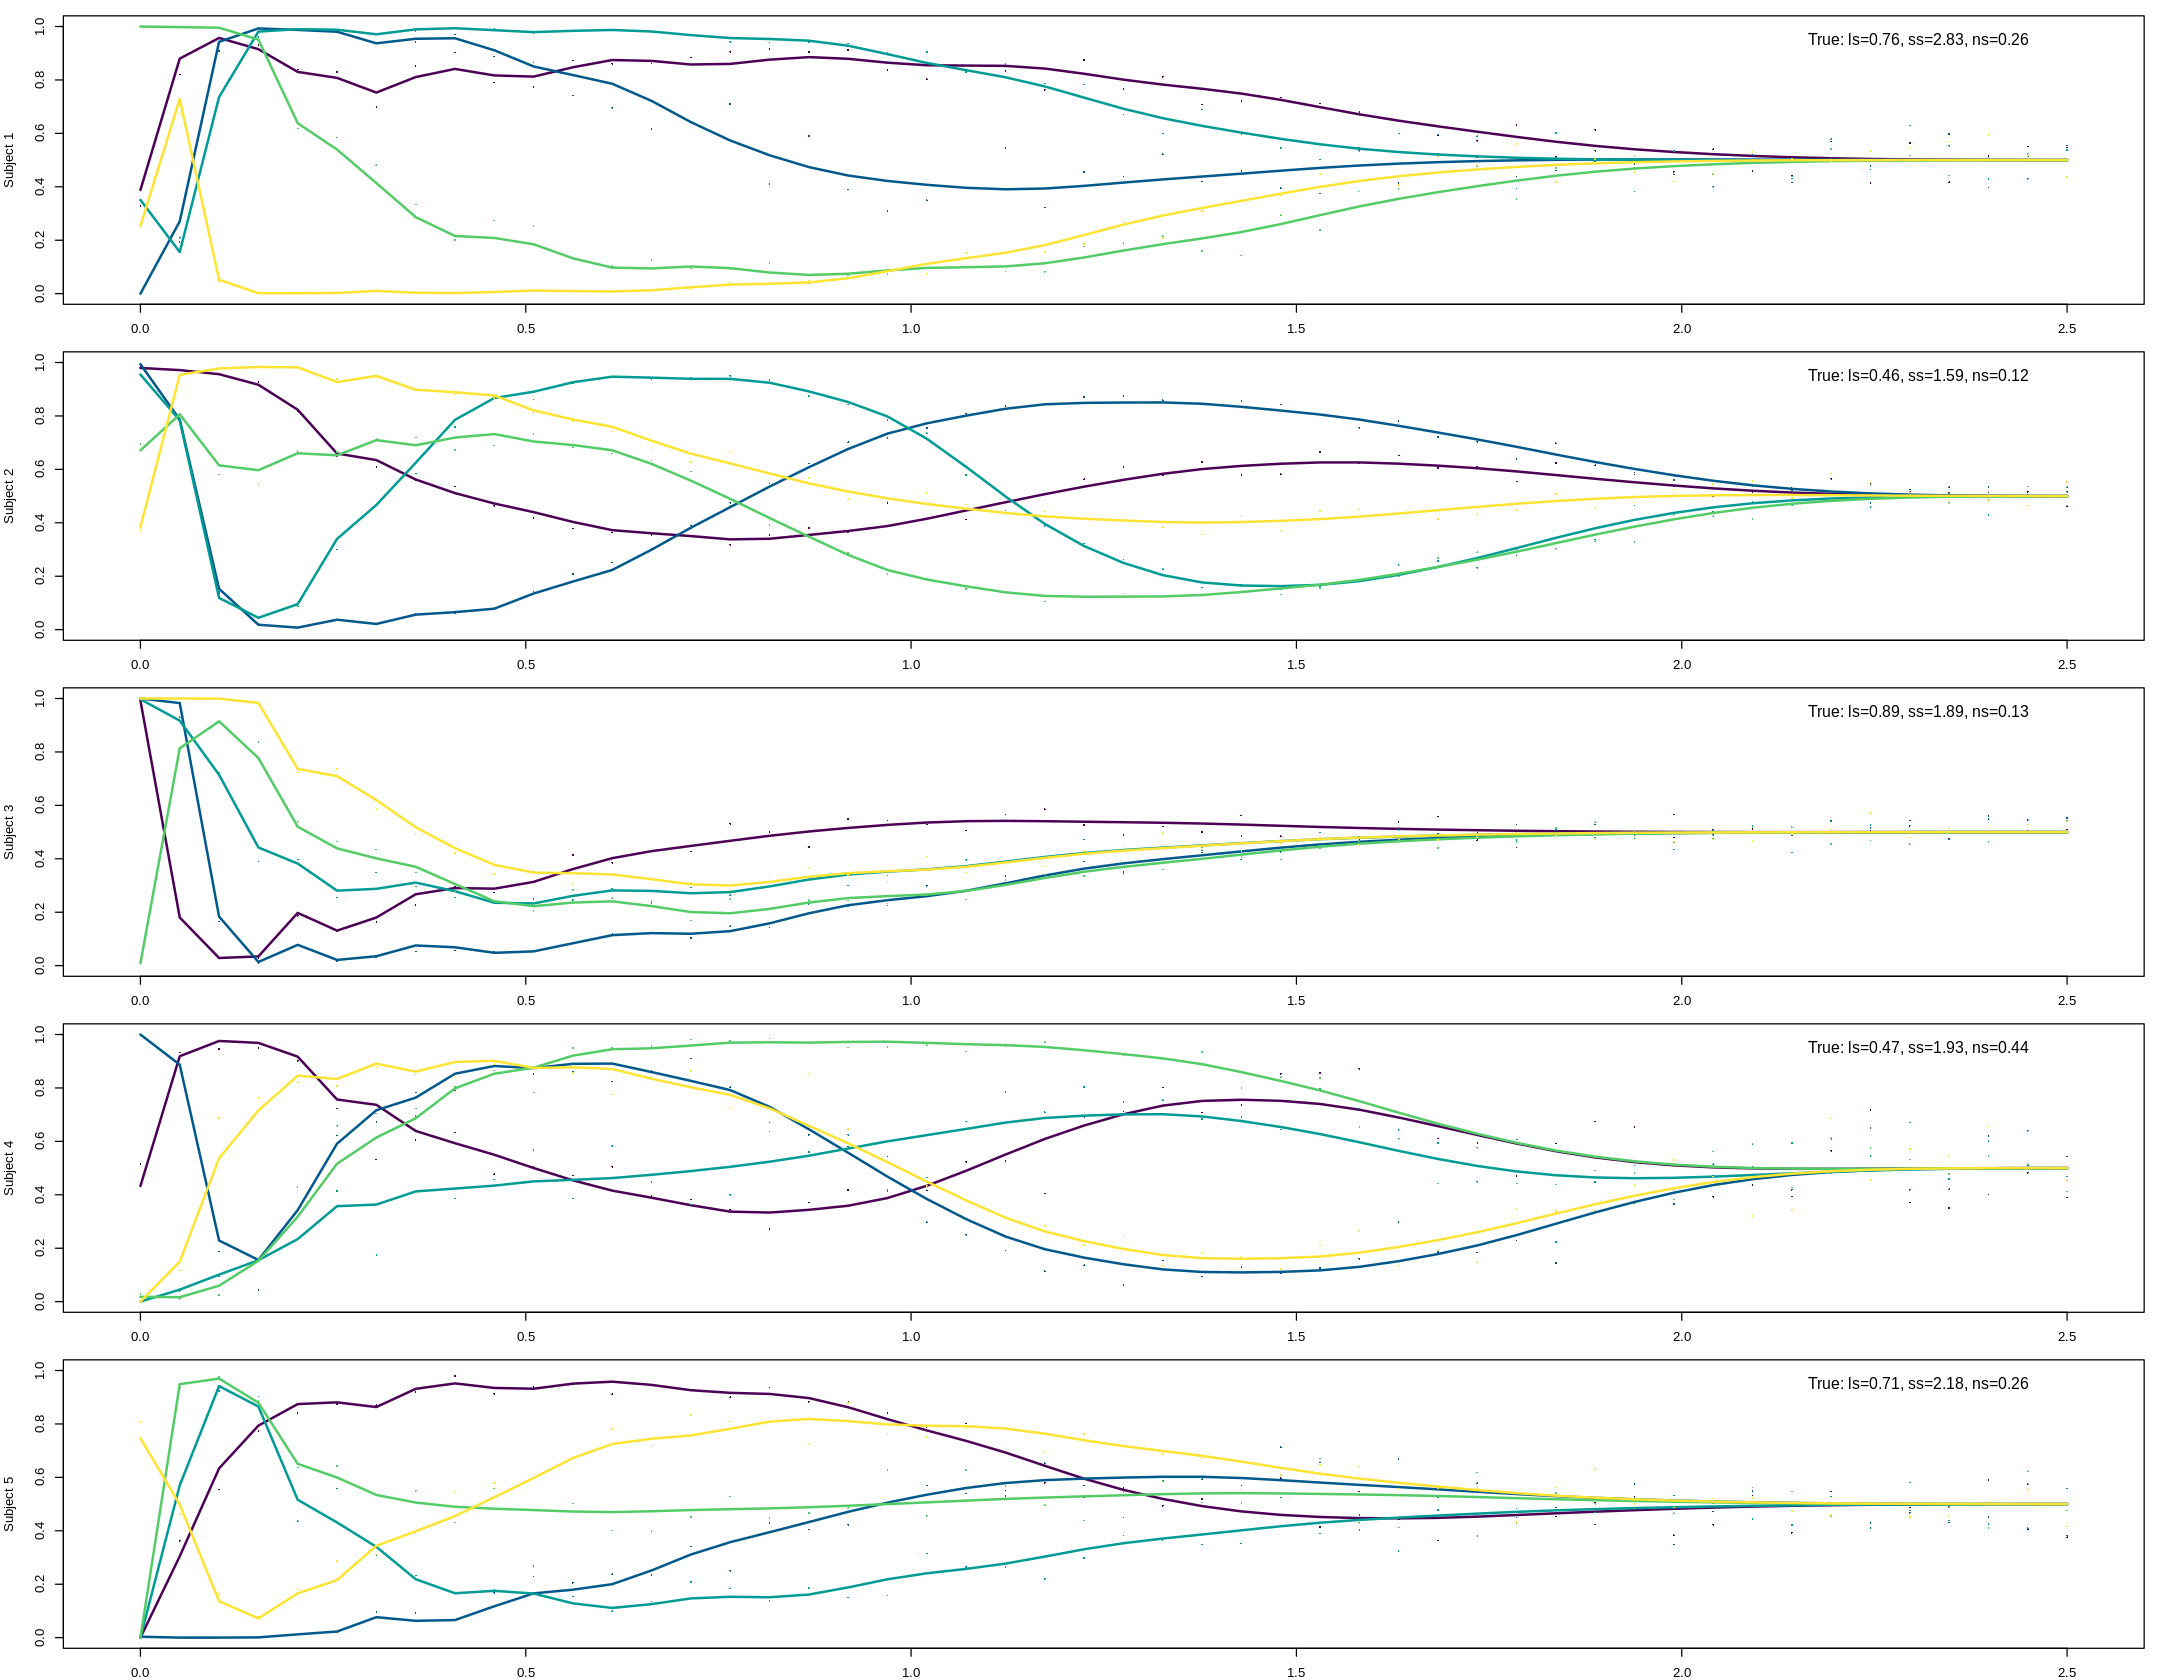

In [15]:
# Visualize data
options(repr.plot.width = 18, repr.plot.height = 14)
par(
    mfrow = c(n_subjects, 1),
    mar = c(2, 4, 1, 1)
)
colors <- hcl.colors(
    n_trials_per_subj,
    "viridis"
)

for (subj in 1:n_subjects) {
    trial_idx <- which(trial_data$subject == subj)

    plot(
        NULL,
        xlim = range(time_grid),
        ylim = c(0, 1),
        xlab = "",
        ylab = sprintf("Subject %d", subj)
    )

    for (j in seq_along(trial_idx)) {
        idx <- trial_idx[j]
        # True GP function
        lines(
            time_grid,
            gp_functions[idx, ],
            col = colors[j],
            lwd = 2
        )
        # Noisy observations
        points(
            time_grid,
            observations[idx, ],
            col = colors[j],
            pch = 16,
            cex = 0.3
        )
    }

    # Add true parameters
    text(
        max(time_grid) * 0.98,
        0.95,
        sprintf(
            "True: ls=%.2f, ss=%.2f, ns=%.2f",
            true_subj_params$length_scale[subj],
            true_subj_params$signal_sd[subj],
            true_subj_params$noise_sd[subj]
        ),
        adj = 1,
        cex = 1.2
    )
}

# Model Definition

In [16]:
hierarchical_gp_model <- "
data {
    int<lower=1> n_obs;              // Observations per trial
    int<lower=1> n_trials;           // Total trials across all subjects
    int<lower=1> n_subjects;         // Number of subjects
    real x[n_obs];                   // Input locations (shared across trials)
    int<lower=1,upper=n_subjects> subject_id[n_trials];  // Subject for each trial
    real<lower=0, upper=1> y[n_trials, n_obs];          // Observations
}

transformed data {
    // Zero mean for GP
    vector[n_obs] gp_mean = rep_vector(0, n_obs);

    // Pre-compute Jacobian for logit transform (constant across iterations)
    real logit_jacobian = 0;
    for (trial in 1:n_trials) {
        for (obs in 1:n_obs) {
            logit_jacobian += -log(y[trial, obs]) - log1m(y[trial, obs]);
        }
    }

    // Pre-compute squared distances for efficiency
    matrix[n_obs, n_obs] dist_sq;
    for (i in 1:n_obs) {
        for (j in i:n_obs) {
            dist_sq[i, j] = square(x[i] - x[j]);
            if (i != j) {
                dist_sq[j, i] = dist_sq[i, j];  // Symmetric
            }
        }
    }

    // Count trials per subject for efficiency
    int trials_per_subject[n_subjects] = rep_array(0, n_subjects);

    for (trial in 1:n_trials) {
        trials_per_subject[subject_id[trial]] += 1;
    }
}

parameters {
    // Population-level parameters on LOG SCALE
    // These represent the mean and SD of the log-normal distribution
    real mu_log_length_scale;              // Mean of log(length_scale) across subjects
    real<lower=0> sigma_log_length_scale;  // SD of log(length_scale) across subjects

    real mu_log_signal_sd;                 // Mean of log(signal_sd) across subjects
    real<lower=0> sigma_log_signal_sd;     // SD of log(signal_sd) across subjects

    real mu_log_noise_sd;                  // Mean of log(noise_sd) across subjects
    real<lower=0> sigma_log_noise_sd;      // SD of log(noise_sd) across subjects

    // Non-centered parameterization: subject-level z-scores
    vector[n_subjects] z_length_scale;     // Standard normal deviates
    vector[n_subjects] z_signal_sd;        // Standard normal deviates
    vector[n_subjects] z_noise_sd;         // Standard normal deviates
}

transformed parameters {
    // Subject-specific parameters on NATURAL SCALE
    vector<lower=0>[n_subjects] length_scale;
    vector<lower=0>[n_subjects] signal_sd;
    vector<lower=0>[n_subjects] noise_sd;

    // Non-centered parameterization: theta = exp(mu + sigma * z)
    // This gives us log-normal distributed parameters
    for (subj in 1:n_subjects) {
        length_scale[subj] = exp(mu_log_length_scale + sigma_log_length_scale * z_length_scale[subj]);
        signal_sd[subj] = exp(mu_log_signal_sd + sigma_log_signal_sd * z_signal_sd[subj]);
        noise_sd[subj] = exp(mu_log_noise_sd + sigma_log_noise_sd * z_noise_sd[subj]);
    }
}

model {
    // Priors on population LOG-SCALE parameters
    // Centered on the log of expected values from data generation
    mu_log_length_scale ~ normal(log(0.5), 0.5);      // log(0.5) ≈ -0.69
    sigma_log_length_scale ~ normal(0, 0.5) T[0,];    // Half-normal, weakly informative

    mu_log_signal_sd ~ normal(log(2.0), 0.5);         // log(2.0) ≈ 0.69
    sigma_log_signal_sd ~ normal(0, 0.5) T[0,];       // Half-normal, weakly informative

    mu_log_noise_sd ~ normal(log(0.3), 0.5);          // log(0.3) ≈ -1.20
    sigma_log_noise_sd ~ normal(0, 0.5) T[0,];        // Half-normal, weakly informative

    // Non-centered parameters have standard normal priors
    z_length_scale ~ std_normal();
    z_signal_sd ~ std_normal();
    z_noise_sd ~ std_normal();

    // Likelihood - process all trials for each subject together to re-use covariance matrix
    for (subj in 1:n_subjects) {
        if (trials_per_subject[subj] > 0) {
            // Build covariance matrix once per subject
            matrix[n_obs, n_obs] K;
            matrix[n_obs, n_obs] L_K;
            real ls_sq = square(length_scale[subj]);
            real ss_sq = square(signal_sd[subj]);
            real ns_sq = square(noise_sd[subj]);

            // Efficient covariance matrix construction
            for (i in 1:n_obs) {
                for (j in i:n_obs) {
                    K[i, j] = ss_sq * exp(-0.5 * dist_sq[i, j] / ls_sq);
                    if (i != j) {
                        K[j, i] = K[i, j];  // Exploit symmetry
                    }
                }
                K[i, i] += ns_sq + 1e-9;  // Add noise variance and jitter on diagonal
            }

            // Cholesky decomposition for numerical stability and efficiency
            L_K = cholesky_decompose(K);

            // Process all trials for this subject
            for (trial in 1:n_trials) {
                if (subject_id[trial] == subj) {
                    vector[n_obs] y_logit;

                    // Transform observations to logit scale
                    for (i in 1:n_obs) {
                        y_logit[i] = logit(y[trial, i]);
                    }

                    // Log likelihood using Cholesky decomposition
                    target += multi_normal_cholesky_lpdf(y_logit | gp_mean, L_K);
                }
            }
        }
    }

    // Add Jacobian adjustment for logit transform (computed once in transformed data)
    target += logit_jacobian;
}

generated quantities {
    // Population parameters on NATURAL SCALE for easier interpretation
    real<lower=0> pop_length_scale_median = exp(mu_log_length_scale);
    real<lower=0> pop_signal_sd_median = exp(mu_log_signal_sd);
    real<lower=0> pop_noise_sd_median = exp(mu_log_noise_sd);

    // Population SDs on natural scale (these are multiplicative factors)
    // For log-normal: SD on log scale becomes multiplicative factor on natural scale
    real<lower=0> pop_length_scale_sd = sigma_log_length_scale;
    real<lower=0> pop_signal_sd_sd = sigma_log_signal_sd;
    real<lower=0> pop_noise_sd_sd = sigma_log_noise_sd;

    // Log likelihood for each trial (for LOO-CV)
    real log_lik[n_trials];

    // Posterior predictive draws for model checking
    real<lower=0, upper=1> y_pred[n_trials, n_obs];

    // Predictions for a new subject
    real<lower=0> new_subj_length_scale;
    real<lower=0> new_subj_signal_sd;
    real<lower=0> new_subj_noise_sd;
    vector<lower=0, upper=1>[n_obs] y_new_subj;

    // Sample hyperparameters for a new subject from population distribution
    new_subj_length_scale = lognormal_rng(mu_log_length_scale, sigma_log_length_scale);
    new_subj_signal_sd = lognormal_rng(mu_log_signal_sd, sigma_log_signal_sd);
    new_subj_noise_sd = lognormal_rng(mu_log_noise_sd, sigma_log_noise_sd);

    // Process existing subjects for log likelihood and predictions
    for (subj in 1:n_subjects) {
        if (trials_per_subject[subj] > 0) {
            // Build covariance matrix
            matrix[n_obs, n_obs] K;
            matrix[n_obs, n_obs] L_K;
            real ls_sq = square(length_scale[subj]);
            real ss_sq = square(signal_sd[subj]);
            real ns_sq = square(noise_sd[subj]);

            for (i in 1:n_obs) {
                for (j in i:n_obs) {
                    K[i, j] = ss_sq * exp(-0.5 * dist_sq[i, j] / ls_sq);
                    if (i != j) {
                        K[j, i] = K[i, j];
                    }
                }
                K[i, i] += ns_sq + 1e-9;
            }

            L_K = cholesky_decompose(K);

            // Process each trial for this subject
            for (trial in 1:n_trials) {
                if (subject_id[trial] == subj) {
                    vector[n_obs] y_logit;
                    vector[n_obs] y_logit_pred;

                    // Compute log likelihood
                    for (i in 1:n_obs) {
                        y_logit[i] = logit(y[trial, i]);
                    }

                    log_lik[trial] = multi_normal_lpdf(y_logit | gp_mean, K);
                    // Include trial's portion of Jacobian for LOO
                    {
                        vector[n_obs] y_vec = to_vector(y[trial]);
                        log_lik[trial] += -sum(log(y_vec) + log1m(y_vec));
                    }

                    // Sample posterior predictive draw
                    y_logit_pred = multi_normal_cholesky_rng(gp_mean, L_K);

                    // Transform to probability scale with bounds
                    for (i in 1:n_obs) {
                        real pred_prob = inv_logit(y_logit_pred[i]);
                        if (pred_prob < 1e-9) pred_prob = 1e-9;
                        if (pred_prob > 1 - 1e-9) pred_prob = 1 - 1e-9;
                        y_pred[trial, i] = pred_prob;
                    }
                }
            }
        }
    }

    // Generate prediction for new subject
    {
        matrix[n_obs, n_obs] K_new;
        matrix[n_obs, n_obs] L_K_new;
        real ls_sq_new = square(new_subj_length_scale);
        real ss_sq_new = square(new_subj_signal_sd);
        real ns_sq_new = square(new_subj_noise_sd);

        for (i in 1:n_obs) {
            for (j in i:n_obs) {
                K_new[i, j] = ss_sq_new * exp(-0.5 * dist_sq[i, j] / ls_sq_new);
                if (i != j) {
                    K_new[j, i] = K_new[i, j];
                }
            }
            K_new[i, i] += ns_sq_new + 1e-9;
        }

        L_K_new = cholesky_decompose(K_new);
        vector[n_obs] gp_new = multi_normal_cholesky_rng(gp_mean, L_K_new);

        for (i in 1:n_obs) {
            real pred_prob = inv_logit(gp_new[i]);
            if (pred_prob < 1e-9) pred_prob = 1e-9;
            if (pred_prob > 1 - 1e-9) pred_prob = 1 - 1e-9;
            y_new_subj[i] = pred_prob;
        }
    }
}
"

In [17]:
# Save model
writeLines(
    hierarchical_gp_model,
    "hierarchical_gp.stan"
)
cat(readLines("hierarchical_gp.stan"), sep = "\n")

# Compile model once
cat("Compiling hierarchical GP model...\n")
compiled_model <- stan_model("hierarchical_gp.stan")


data {
    int<lower=1> n_obs;              // Observations per trial
    int<lower=1> n_trials;           // Total trials across all subjects
    int<lower=1> n_subjects;         // Number of subjects
    real x[n_obs];                   // Input locations (shared across trials)
    int<lower=1,upper=n_subjects> subject_id[n_trials];  // Subject for each trial
    real<lower=0, upper=1> y[n_trials, n_obs];          // Observations
}

transformed data {
    // Zero mean for GP
    vector[n_obs] gp_mean = rep_vector(0, n_obs);
    
    // Pre-compute Jacobian for logit transform (constant across iterations)
    real logit_jacobian = 0;
    for (trial in 1:n_trials) {
        for (obs in 1:n_obs) {
            logit_jacobian += -log(y[trial, obs]) - log1m(y[trial, obs]);
        }
    }
    
    // Pre-compute squared distances for efficiency
    matrix[n_obs, n_obs] dist_sq;
    for (i in 1:n_obs) {
        for (j in i:n_obs) {
            dist_sq[i, j] = square(x[i] - x[j]);
         

# Model Fitting

In [18]:
# Initialization function
init_fun <- function() {
    list(
        # Population means on log scale
        mu_log_length_scale = log(0.5) + rnorm(1, 0, 0.1),
        mu_log_signal_sd = log(2.0) + rnorm(1, 0, 0.1),
        mu_log_noise_sd = log(0.3) + rnorm(1, 0, 0.1),

        # Population SDs (positive, small values)
        sigma_log_length_scale = runif(1, 0.2, 0.4),
        sigma_log_signal_sd = runif(1, 0.1, 0.3),
        sigma_log_noise_sd = runif(1, 0.2, 0.4),

        # Non-centered parameters (standard normal)
        z_length_scale = rnorm(n_subjects, 0, 0.3),
        z_signal_sd = rnorm(n_subjects, 0, 0.3),
        z_noise_sd = rnorm(n_subjects, 0, 0.3)
    )
}

In [19]:
cat("Fitting hierarchical GP model...\n")
fit <- sampling(
    object = compiled_model,
    data = stan_data,
    iter = 5000,
    warmup = 2000,
    chains = 4,
    seed = 123,
    control = list(
        adapt_delta = 0.95,
        max_treedepth = 10
    ),
    init = init_fun
)

Fitting hierarchical GP model...


# Model Diagnostics

In [20]:
cat("=== MODEL SUMMARY ===\n")
print(
    fit,
    pars = c(
        "mu_log_length_scale",
        "mu_log_signal_sd",
        "mu_log_noise_sd",
        "sigma_log_length_scale",
        "sigma_log_signal_sd",
        "sigma_log_noise_sd",
        "pop_length_scale_median",
        "pop_signal_sd_median",
        "pop_noise_sd_median",
        "pop_length_scale_sd",
        "pop_signal_sd_sd",
        "pop_noise_sd_sd"
    ),
    probs = c(0.025, 0.5, 0.975)
)

=== MODEL SUMMARY ===
Inference for Stan model: anon_model.
4 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

                         mean se_mean   sd  2.5%   50% 97.5% n_eff Rhat
mu_log_length_scale     -1.96       0 0.18 -2.24 -2.00 -1.49  3956    1
mu_log_signal_sd         0.95       0 0.12  0.69  0.96  1.19  5978    1
mu_log_noise_sd         -1.12       0 0.20 -1.51 -1.12 -0.73  4371    1
sigma_log_length_scale   0.32       0 0.17  0.12  0.28  0.77  4984    1
sigma_log_signal_sd      0.22       0 0.13  0.02  0.20  0.54  4884    1
sigma_log_noise_sd       0.46       0 0.16  0.23  0.43  0.85  6147    1
pop_length_scale_median  0.14       0 0.03  0.11  0.14  0.22  3610    1
pop_signal_sd_median     2.61       0 0.31  2.00  2.61  3.27  6145    1
pop_noise_sd_median      0.33       0 0.07  0.22  0.33  0.48  4359    1
pop_length_scale_sd      0.32       0 0.17  0.12  0.28  0.77  4984    1
pop_signal_sd_sd         0.22

In [21]:
# Convergence diagnostics
cat("=== CONVERGENCE DIAGNOSTICS ===\n")

# HMC-specific diagnostics
check_hmc_diagnostics(fit)

# R-hat values
sum_stats <- summary(
    fit,
    pars = c("length_scale", "signal_sd", "noise_sd"),
    probs = c(0.025, 0.5, 0.975)
)$summary

rhats <- sum_stats[, "Rhat"]
max_rhat <- max(
    rhats,
    na.rm = TRUE
)
cat(
    sprintf(
        "\nMax R-hat: %.3f %s\n",
        max_rhat,
        ifelse(
            max_rhat > 1.01,
            "[WARNING]",
            "[OK]"
        )
    )
)

=== CONVERGENCE DIAGNOSTICS ===

Divergences:


0 of 12000 iterations ended with a divergence.




Tree depth:


0 of 12000 iterations saturated the maximum tree depth of 10.




Energy:


E-BFMI indicated no pathological behavior.




Max R-hat: 1.001 [OK]


In [22]:
# Parameter names
param_names <- c(
    "mu_log_length_scale",
    "mu_log_signal_sd",
    "mu_log_noise_sd",
    "sigma_log_length_scale",
    "sigma_log_signal_sd",
    "sigma_log_noise_sd"
)

# Convert stanfit to a draws object
draws <- as_draws_array(fit)

# Compute bulk and tail ESS for the three parameter families
ess_bulk_vals <- ess_bulk(draws, variable = param_names)
ess_tail_vals <- ess_tail(draws, variable = param_names)

# Find minima
min_bulk <- min(ess_bulk_vals, na.rm = TRUE)
min_tail <- min(ess_tail_vals, na.rm = TRUE)

cat(
    sprintf(
        "Min bulk ESS: %.0f %s\n",
        min_bulk,
        ifelse(
            min_bulk < 100 * 4,
            "[WARNING]",
            "[OK]"
        )
    )
)
cat(
    sprintf(
        "Min tail ESS: %.0f %s\n",
        min_tail,
        ifelse(
            min_tail < 100 * 4,
            "[WARNING]",
            "[OK]"
        )
    )
)

Min bulk ESS: 620 [OK]
Min tail ESS: 68 [WARNING]


In [23]:
# Model evaluation via LOO
cat("=== LOO EVALUATION ===\n")
log_lik <- extract_log_lik(
    fit,
    merge_chains = FALSE
)
r_eff <- relative_eff(log_lik)  # Pass log-likelihood directly
loo_results <- loo(
    log_lik,
    r_eff = r_eff,
    cores = 2
)
print(loo_results)

=== LOO EVALUATION ===


Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”



Computed from 12000 by 25 log-likelihood matrix.

         Estimate    SE
elpd_loo    723.1 119.8
p_loo        70.2  13.8
looic     -1446.2 239.6
------
MCSE of elpd_loo is NA.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.8, 1.2]).

Pareto k diagnostic values:
                         Count Pct.    Min. ESS
(-Inf, 0.7]   (good)     19    76.0%   300     
   (0.7, 1]   (bad)       3    12.0%   <NA>    
   (1, Inf)   (very bad)  3    12.0%   <NA>    
See help('pareto-k-diagnostic') for details.


In [24]:
# Parameter recovery analysis
posterior <- extract(fit)

# Population parameters
pop_recovery <- rbind(
    calc_recovery(
        posterior$pop_length_scale_median,
        true_pop_medians["length_scale"],
        "pop_length_scale_median"
    ),
    calc_recovery(
        posterior$pop_signal_sd_median,
        true_pop_medians["signal_sd"],
        "pop_signal_sd_median"
    ),
    calc_recovery(
        posterior$pop_noise_sd_median,
        true_pop_medians["noise_sd"],
        "pop_noise_sd_median"
    ),
    calc_recovery(
        posterior$pop_length_scale_sd,
        true_pop_sds["length_scale"],
        "pop_length_scale_sd (log scale)"
    ),
    calc_recovery(
        posterior$pop_signal_sd_sd,
        true_pop_sds["signal_sd"],
        "pop_signal_sd_sd (log scale)"
    ),
    calc_recovery(
        posterior$pop_noise_sd_sd,
        true_pop_sds["noise_sd"],
        "pop_noise_sd_sd (log scale)"
    )
)

cat("=== PARAMETER RECOVERY ===\n")
print(
    pop_recovery,
    row.names = FALSE,
    digits = 3
)
cat(
    sprintf(
        "\nPopulation parameter coverage: %.0f%%\n",
        mean(pop_recovery$Covered) * 100
    )
)

=== PARAMETER RECOVERY ===
                       Parameter  True Posterior_Mean CI_Lower CI_Upper
         pop_length_scale_median 0.500          0.143   0.1069    0.225
            pop_signal_sd_median 2.000          2.614   1.9991    3.271
             pop_noise_sd_median 0.300          0.332   0.2200    0.480
 pop_length_scale_sd (log scale) 0.309          0.320   0.1155    0.773
    pop_signal_sd_sd (log scale) 0.157          0.219   0.0205    0.542
     pop_noise_sd_sd (log scale) 0.325          0.458   0.2345    0.850
 Bias_Percent Covered
       -71.41   FALSE
        30.71    TRUE
        10.66    TRUE
         3.78    TRUE
        39.24    TRUE
        41.19    TRUE

Population parameter coverage: 83%


In [25]:
# Log-scale parameter recovery
log_scale_params <- rbind(
    data.frame(
        param = "mu_log_length_scale",
        true_value = log(true_pop_medians["length_scale"]),
        posterior_mean = mean(posterior$mu_log_length_scale),
        posterior_sd = sd(posterior$mu_log_length_scale)
    ),
    data.frame(
        param = "mu_log_signal_sd",
        true_value = log(true_pop_medians["signal_sd"]),
        posterior_mean = mean(posterior$mu_log_signal_sd),
        posterior_sd = sd(posterior$mu_log_signal_sd)
    ),
    data.frame(
        param = "mu_log_noise_sd",
        true_value = log(true_pop_medians["noise_sd"]),
        posterior_mean = mean(posterior$mu_log_noise_sd),
        posterior_sd = sd(posterior$mu_log_noise_sd)
    )
)

cat("Log-scale parameter recovery:\n")
print(
    log_scale_params,
    row.names = FALSE,
    digits = 3
)

Log-scale parameter recovery:
               param true_value posterior_mean posterior_sd
 mu_log_length_scale     -0.693         -1.964        0.184
    mu_log_signal_sd      0.693          0.954        0.121
     mu_log_noise_sd     -1.204         -1.122        0.195


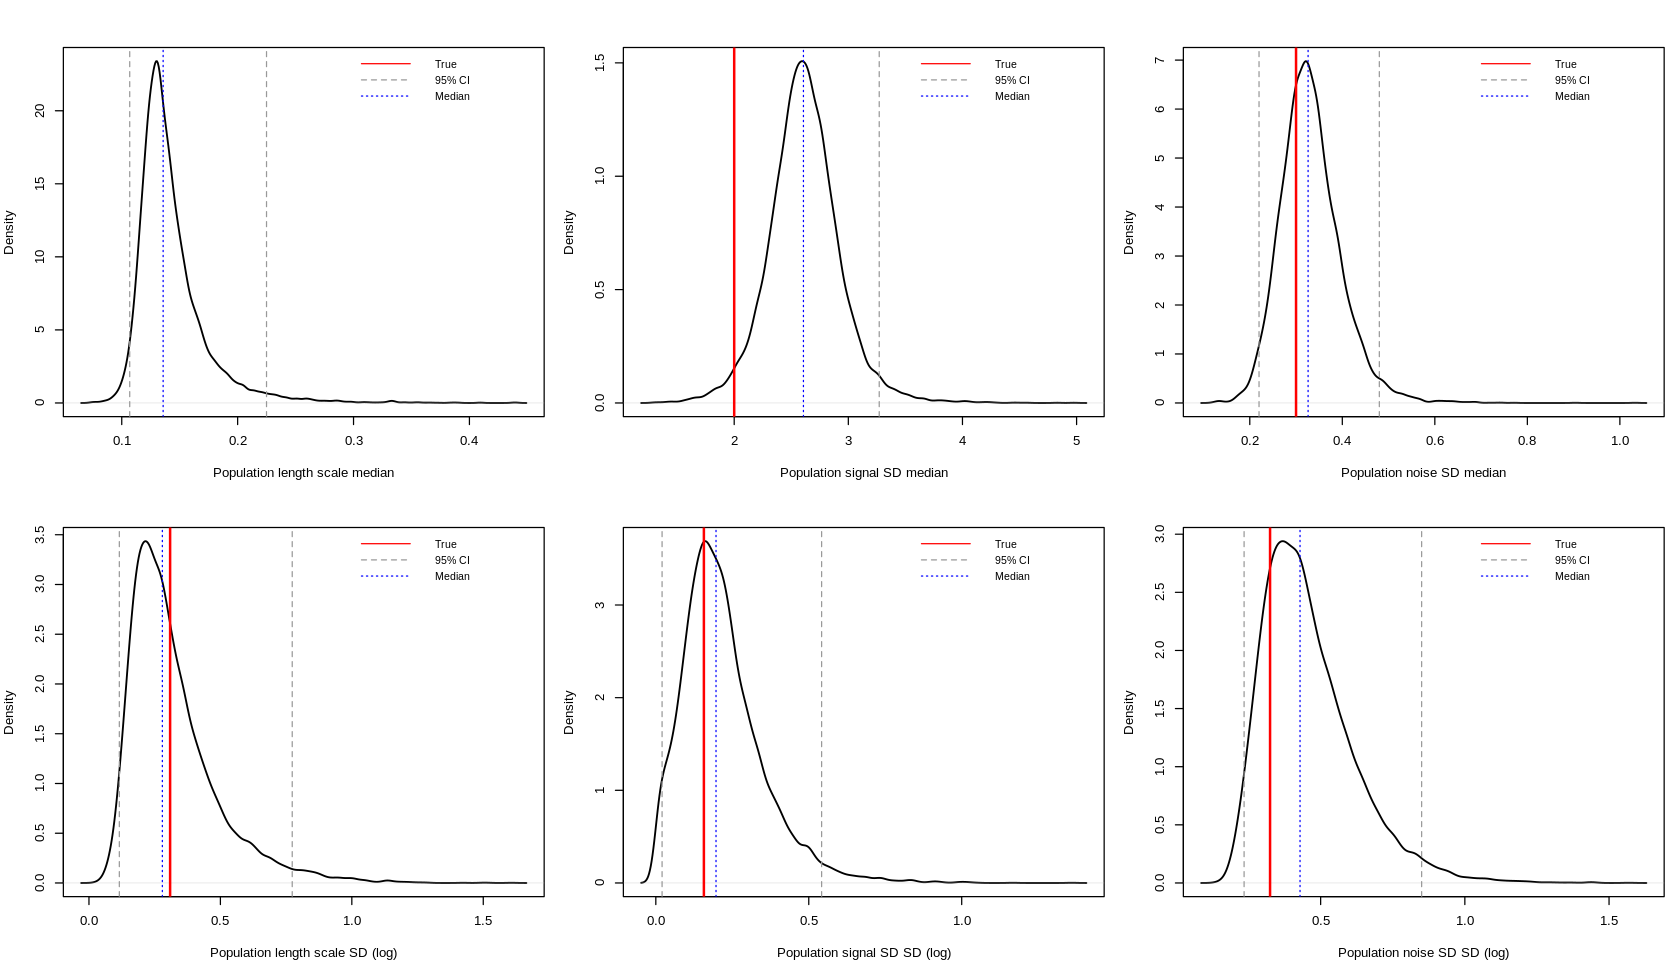

In [26]:
# Population parameters
options(repr.plot.width = 14, repr.plot.height = 8)
par(
    mfrow = c(2, 3),
    mar = c(4, 4, 3, 1)
)

plot_posterior(
    posterior$pop_length_scale_median,
    true_pop_medians["length_scale"],
    "Population length scale median"
)

plot_posterior(
    posterior$pop_signal_sd_median,
    true_pop_medians["signal_sd"],
    "Population signal SD median"
)

plot_posterior(
    posterior$pop_noise_sd_median,
    true_pop_medians["noise_sd"],
    "Population noise SD median"
)

plot_posterior(
    posterior$pop_length_scale_sd,
    true_pop_sds["length_scale"],
    "Population length scale SD (log)"
)

plot_posterior(
    posterior$pop_signal_sd_sd,
    true_pop_sds["signal_sd"],
    "Population signal SD SD (log)"
)

plot_posterior(
    posterior$pop_noise_sd_sd,
    true_pop_sds["noise_sd"],
    "Population noise SD SD (log)"
)

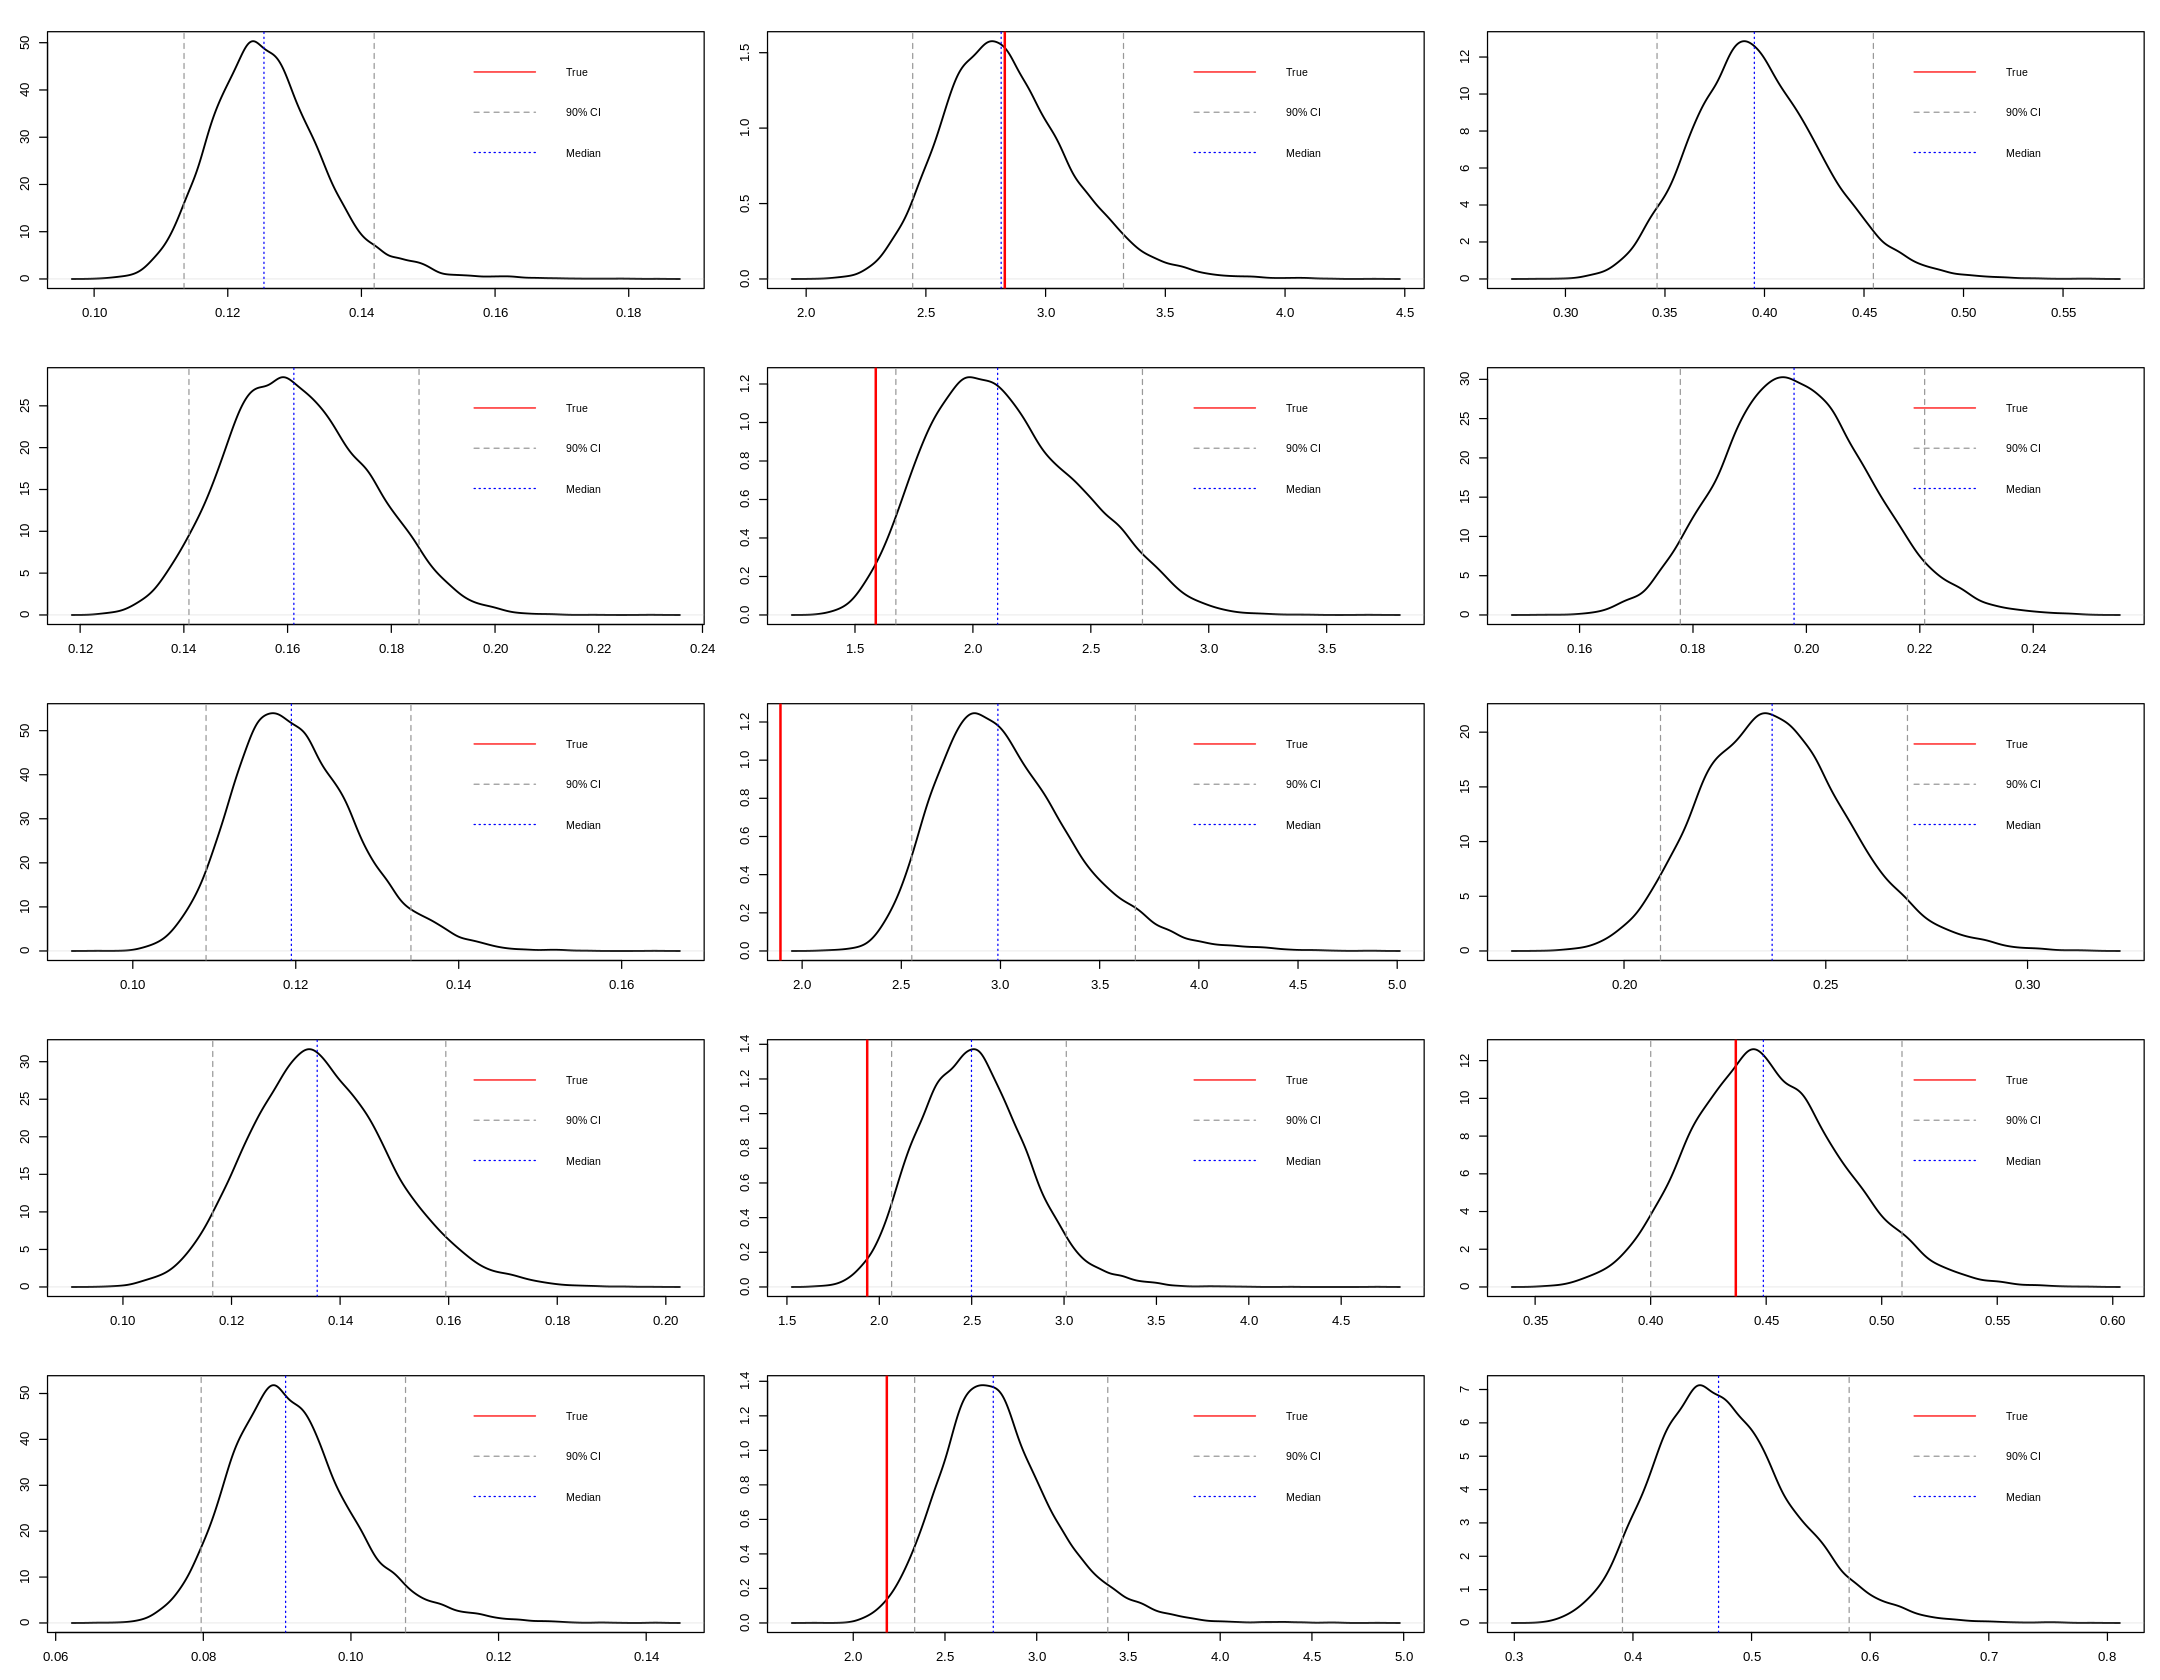

In [27]:
# Subject parameters
options(repr.plot.width = 18, repr.plot.height = 14)
par(
    mfrow = c(n_subjects, 3),
    mar = c(3, 3, 2, 1)
)

for (subj in 1:n_subjects) {
    plot_posterior(
        posterior$length_scale[, subj],
        true_subj_params$length_scale[subj],
        sprintf("S%d length scale", subj),
        ci_level = 0.90
    )

    plot_posterior(
        posterior$signal_sd[, subj],
        true_subj_params$signal_sd[subj],
        sprintf("S%d signal SD", subj),
        ci_level = 0.90
    )

    plot_posterior(
        posterior$noise_sd[, subj],
        true_subj_params$noise_sd[subj],
        sprintf("S%d noise SD", subj),
        ci_level = 0.90
    )
}

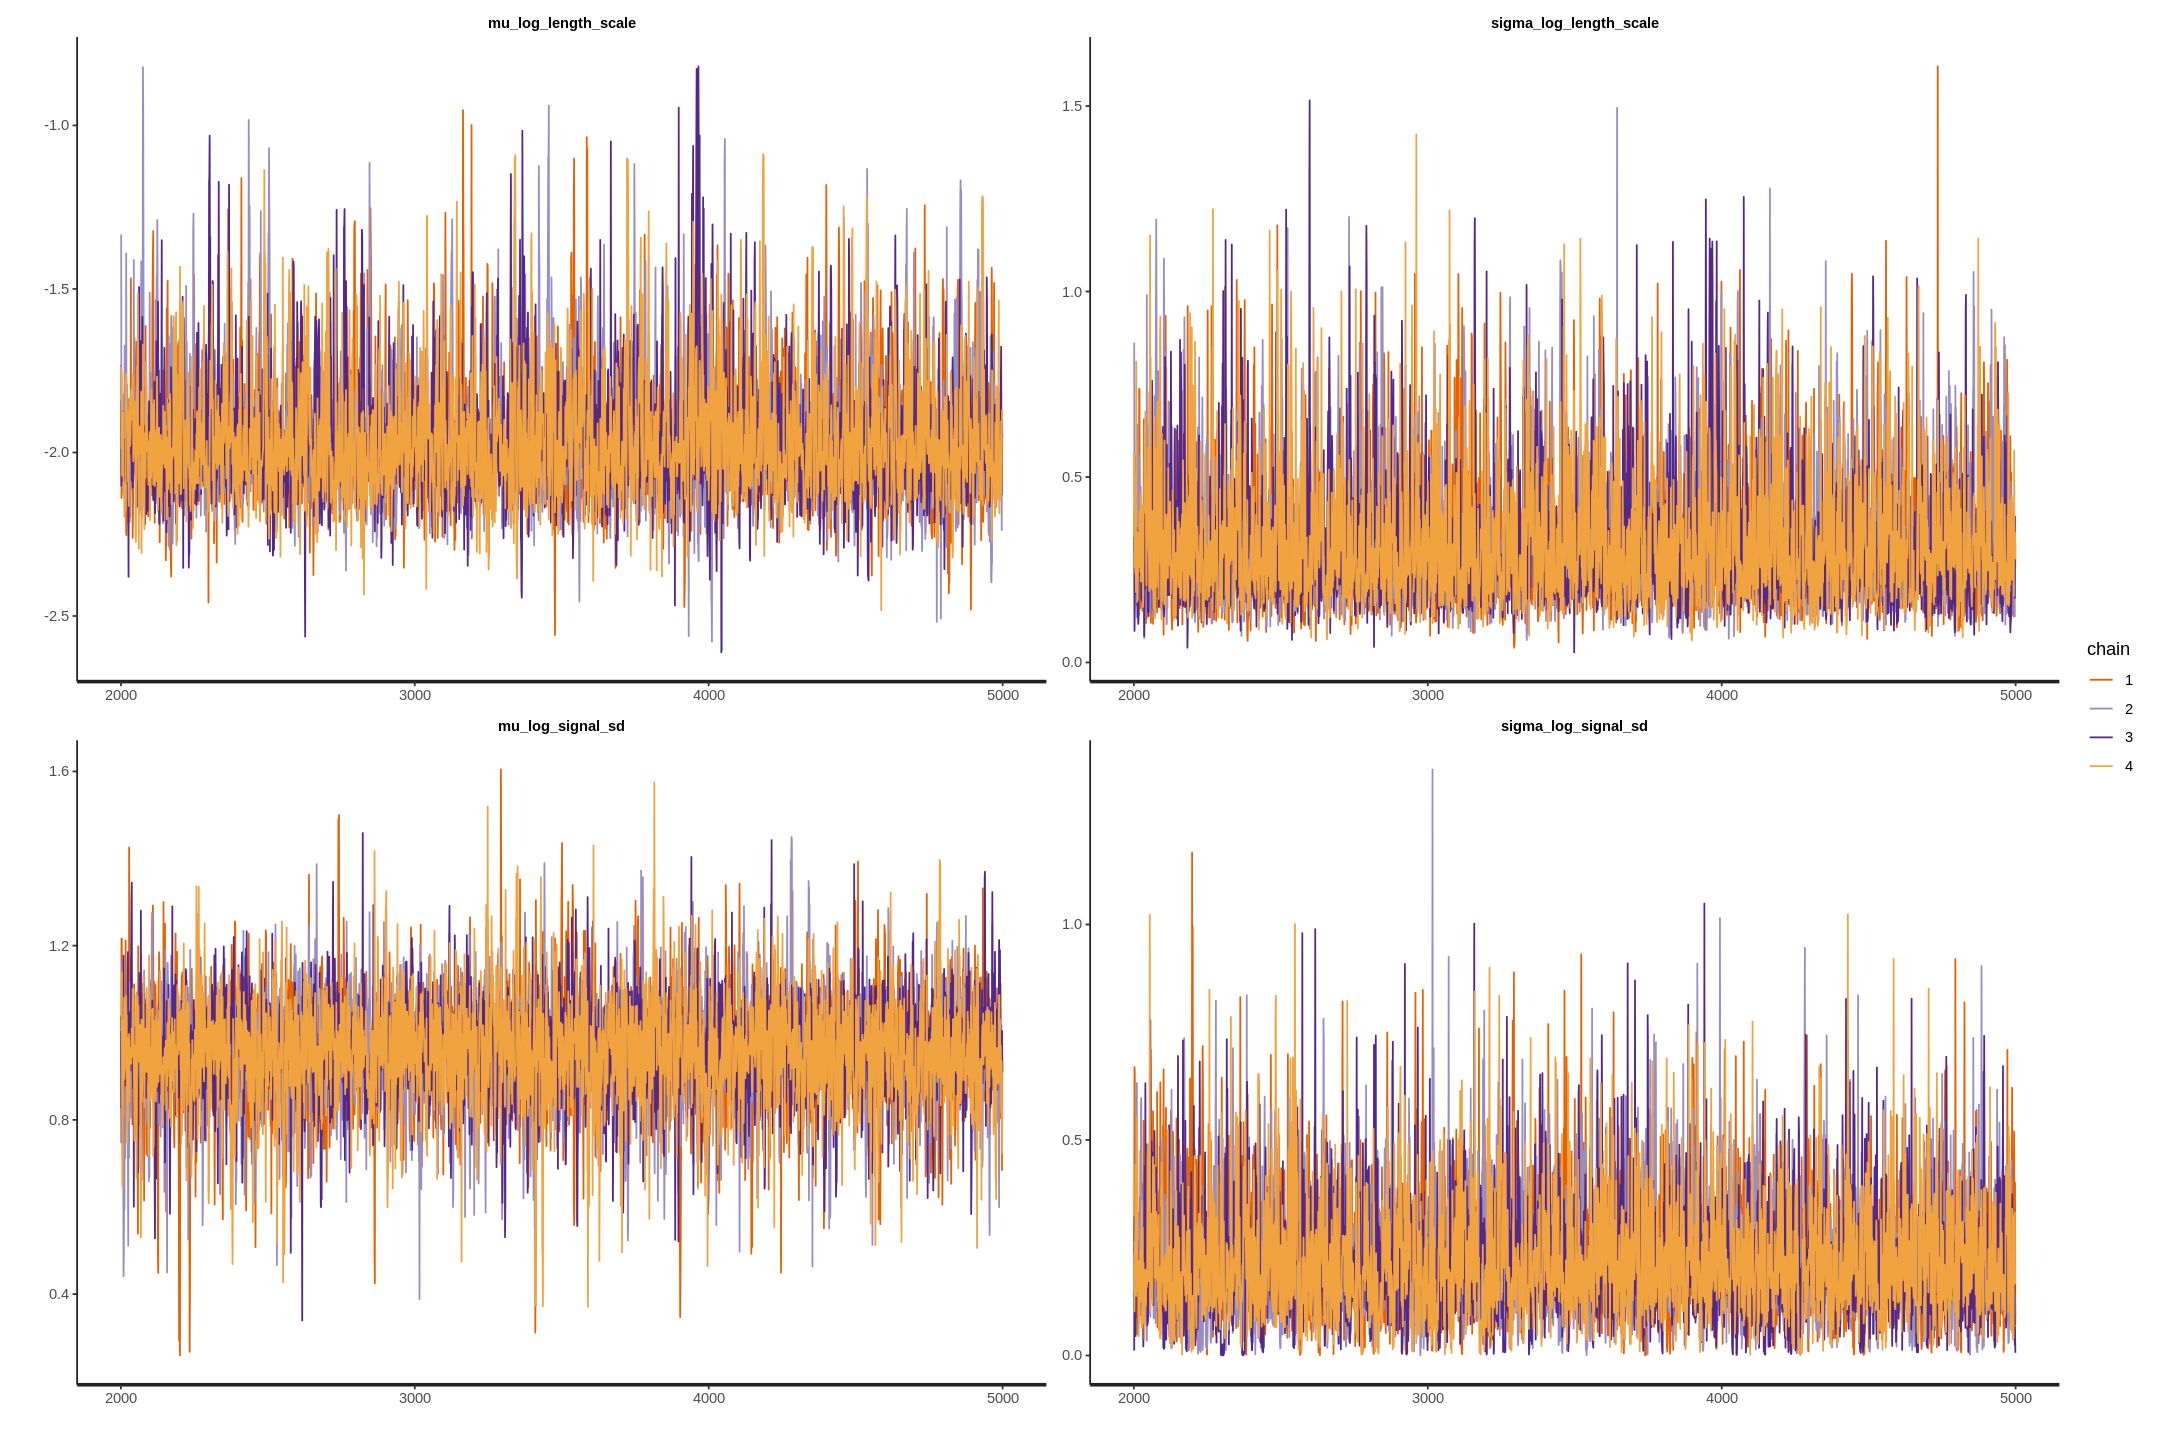

In [28]:
# Trace plots
options(repr.plot.width = 18, repr.plot.height = 12)
traceplot(
    fit,
    pars = c(
        "mu_log_length_scale",
        "sigma_log_length_scale",
        "mu_log_signal_sd",
        "sigma_log_signal_sd"
    ),
    ncol = 2
)

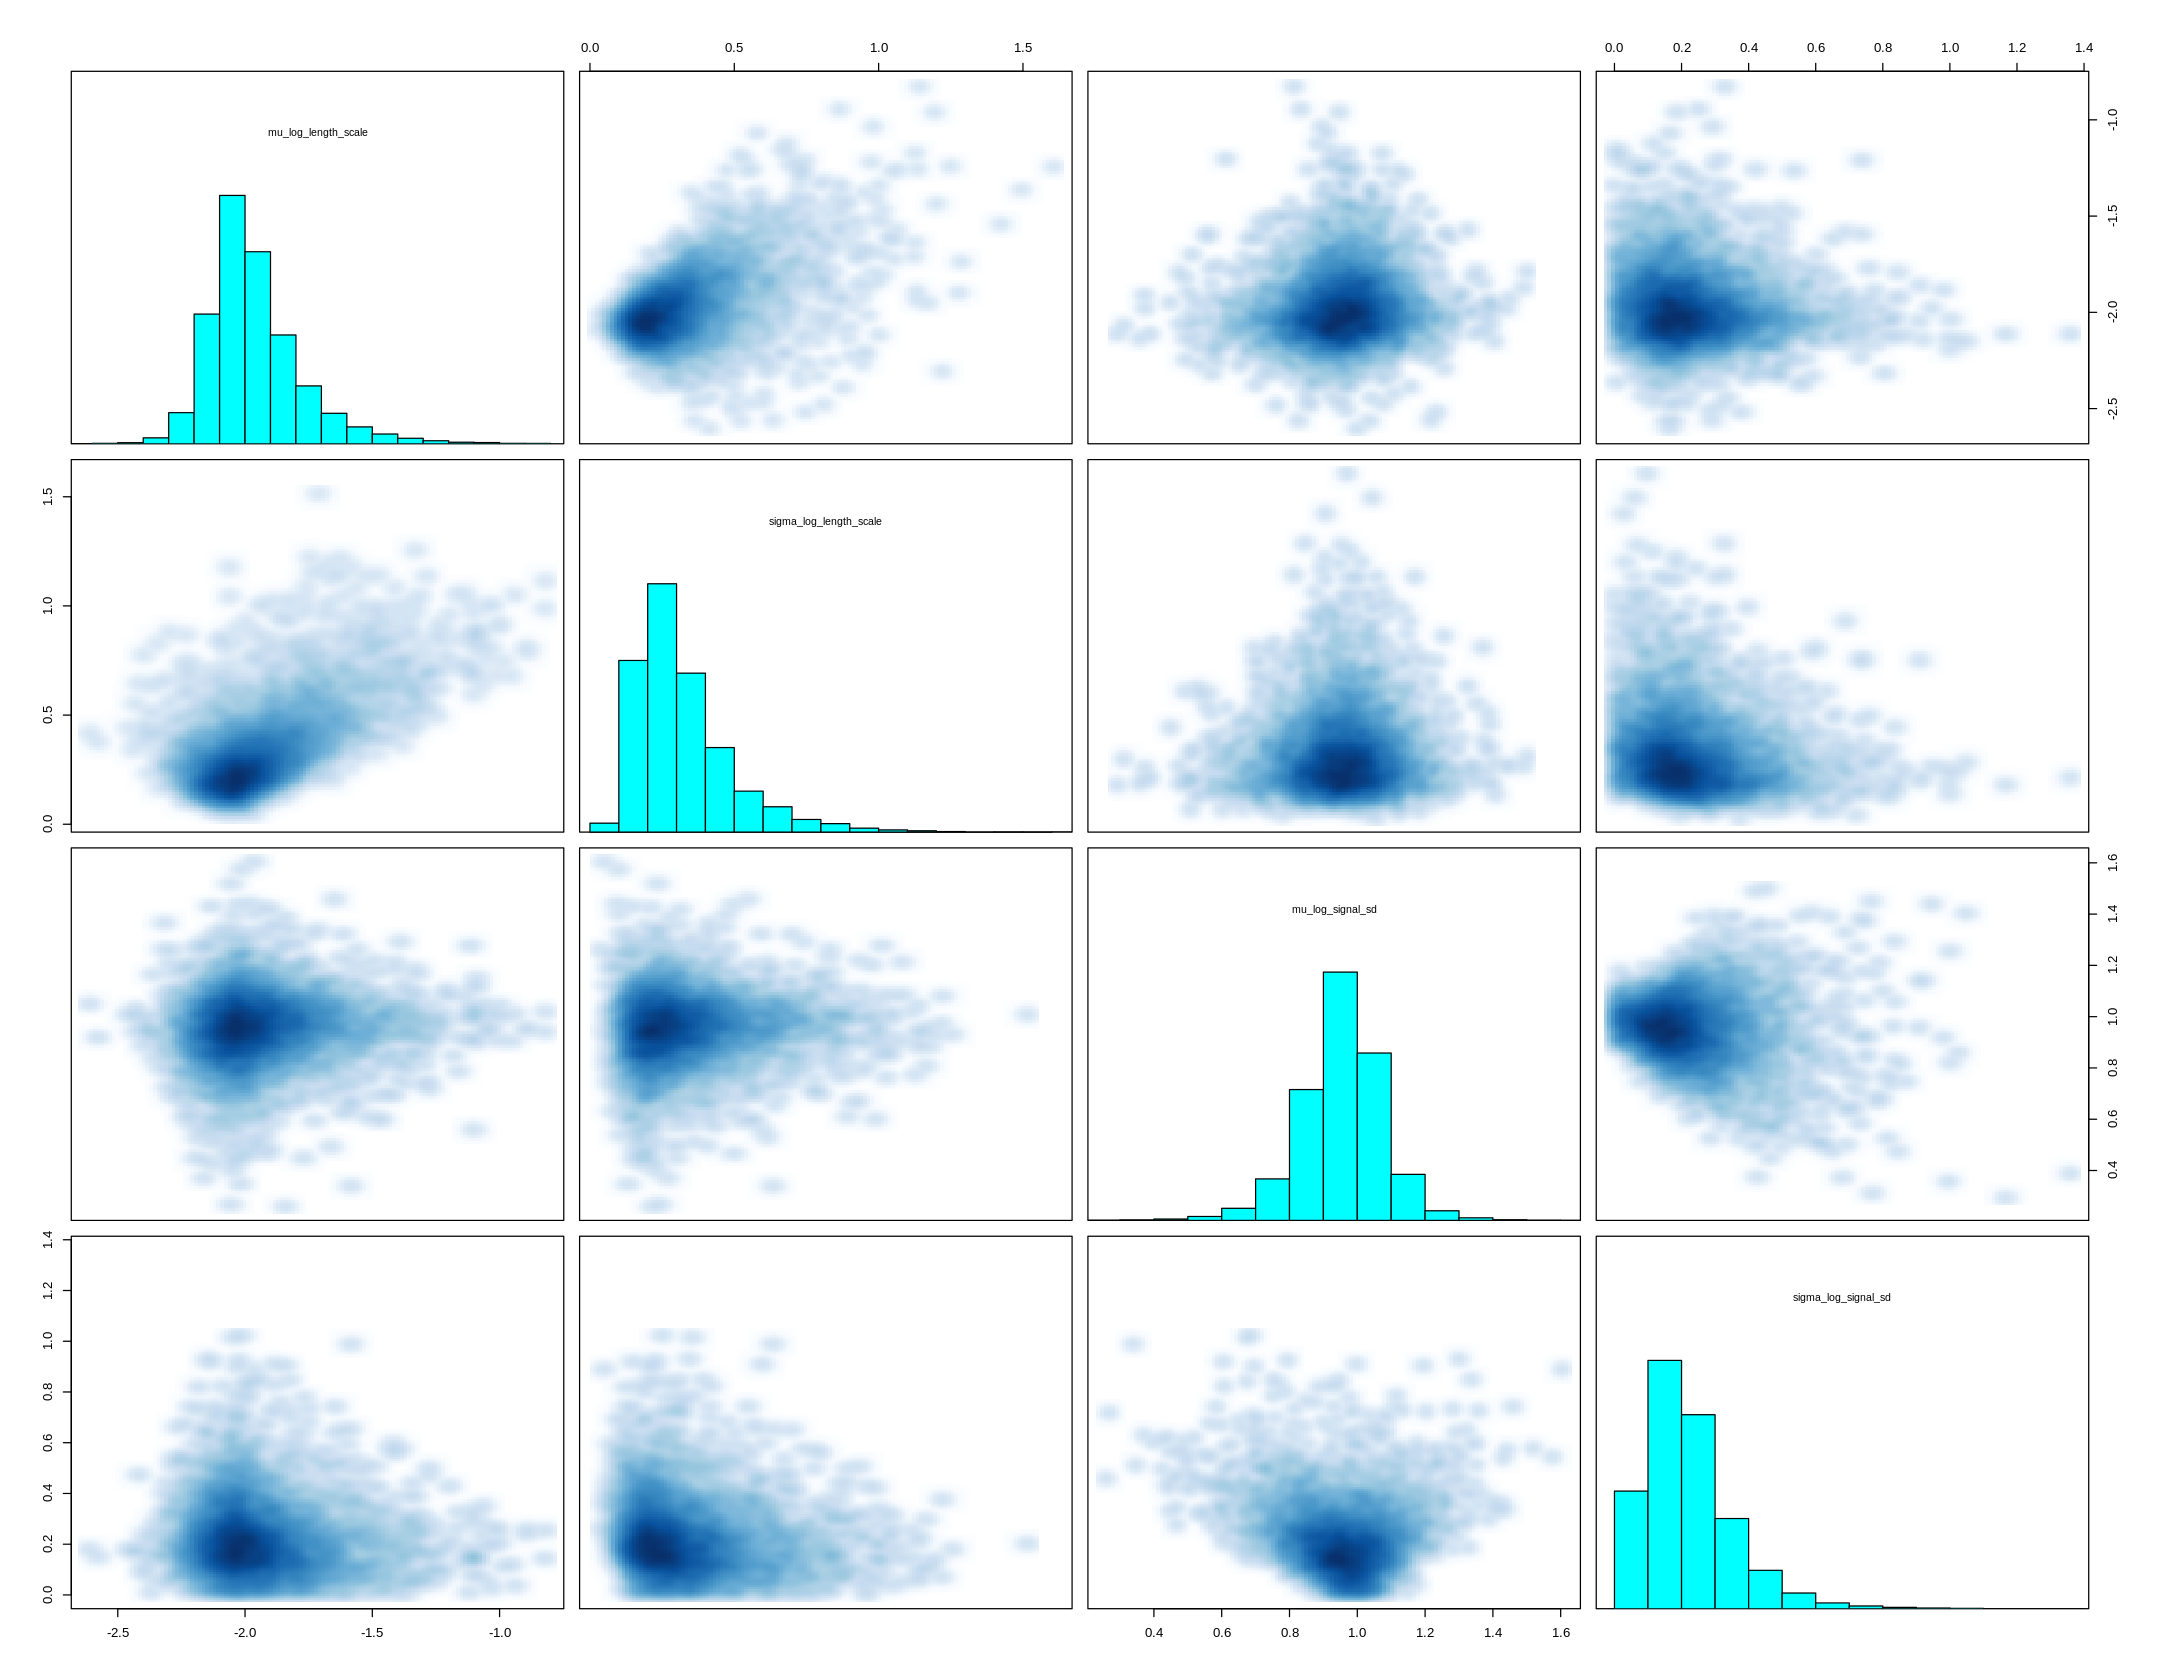

In [29]:
# Pairs plot
options(repr.plot.width = 18, repr.plot.height = 14)
suppressWarnings(
  pairs(
    fit,
    pars = c(
        "mu_log_length_scale",
        "sigma_log_length_scale",
        "mu_log_signal_sd",
        "sigma_log_signal_sd"
    )
  )
)

# Predictive Check

In [30]:
cat("=== EXTRACTING PREDICTIONS ===\n")
y_pred <- extract(fit)$y_pred
y_new_subj <- extract(fit)$y_new_subj
new_subj_params <- data.frame(
    length_scale = extract(fit)$new_subj_length_scale,
    signal_sd = extract(fit)$new_subj_signal_sd,
    noise_sd = extract(fit)$new_subj_noise_sd
)

=== EXTRACTING PREDICTIONS ===


In [31]:
cat("=== POSTERIOR PREDICTIVE CHECKS ===\n")

# Calculate coverage
coverage_95 <- matrix(0, n_trials_total, n_timepoints)
coverage_80 <- matrix(0, n_trials_total, n_timepoints)
coverage_50 <- matrix(0, n_trials_total, n_timepoints)

for (trial in 1:n_trials_total) {
    for (obs in 1:n_timepoints) {
        pred_quantiles <- quantile(
            y_pred[, trial, obs],
            c(0.025, 0.1, 0.25, 0.75, 0.9, 0.975)
        )

        coverage_95[trial, obs] <- observations[trial, obs] >= pred_quantiles[1] &
                                  observations[trial, obs] <= pred_quantiles[6]
        coverage_80[trial, obs] <- observations[trial, obs] >= pred_quantiles[2] &
                                  observations[trial, obs] <= pred_quantiles[5]
        coverage_50[trial, obs] <- observations[trial, obs] >= pred_quantiles[3] &
                                  observations[trial, obs] <= pred_quantiles[4]
    }
}

cat(sprintf("Prediction interval coverage:\n"))
cat(sprintf("  95%% PI: %.1f%% (should be ~95%%)\n", mean(coverage_95) * 100))
cat(sprintf("  80%% PI: %.1f%% (should be ~80%%)\n", mean(coverage_80) * 100))
cat(sprintf("  50%% PI: %.1f%% (should be ~50%%)\n", mean(coverage_50) * 100))

=== POSTERIOR PREDICTIVE CHECKS ===
Prediction interval coverage:
  95% PI: 98.2% (should be ~95%)
  80% PI: 93.5% (should be ~80%)
  50% PI: 79.6% (should be ~50%)


In [32]:
# Coverage by subject
cat("Coverage by subject (95% PI):\n")
for (subj in 1:n_subjects) {
    subj_trials <- which(trial_data$subject == subj)
    subj_coverage <- mean(coverage_95[subj_trials, ])
    cat(sprintf("  Subject %d: %.1f%%\n", subj, subj_coverage * 100))
}

Coverage by subject (95% PI):
  Subject 1: 96.8%
  Subject 2: 99.2%
  Subject 3: 98.4%
  Subject 4: 98.8%
  Subject 5: 97.6%
